In [3]:
from selenium import webdriver
from selenium .webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import time
from tqdm.notebook import tqdm
import re
import matplotlib as plt
import matplotlib.font_manager as fm
import pandas as pd
from selenium.common.exceptions import StaleElementReferenceException
from selenium.common.exceptions import ElementClickInterceptedException
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
#Font -> koreanize_matplotlib doesn't work in my environment
#font_path = 'C:/Windows/Fonts/gulim.ttc'
#font_name = fm.FontProperties(fname=font_path).get_name()
#plt.rc('font', family=font_name)




### Open website

In [4]:
options = webdriver.ChromeOptions() 
url = "https://www.imdb.com/"
driver = webdriver.Chrome(service = Service('../../driver/chromedriver-linux64/chromedriver'))
driver.get(url)
driver.set_window_size(1500, 768)

### 검색 후 The Big bang Theory 클릭

In [9]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

searchbar = driver.find_element(By.ID, "suggestion-search")
searchbar.send_keys("The Big Bang Theory")
driver.find_element(By.ID, "suggestion-search-button").click()
driver.find_element(By.CLASS_NAME, "ipc-metadata-list-summary-item__t").click() 

### scroll down 한다음에 episodes 클릭

In [10]:
episode = driver.find_element(By.CLASS_NAME, "ipc-title.ipc-title--base.ipc-title--section-title.ipc-title--on-textPrimary")
driver.execute_script("arguments[0].scrollIntoView();", episode) #Scroll down to click "episode"
wait = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CLASS_NAME, "ipc-title-link-wrapper")))
'''while True:
    try: 
        wait.click()
        break
    except ElementClickInterceptedException:
        time.sleep(0.1)
        continue
'''
driver.execute_script("arguments[0].click();", wait)
# Scroll down to make seasons panel visible
season_div = driver.find_element(By.CLASS_NAME, "ipc-tabs.ipc-tabs--base.ipc-tabs--align-left.ipc-tabs--display-chip.ipc-tabs--inherit")
driver.execute_script("arguments[0].scrollIntoView();",season_div )


# 시즌별 각 에피소드 정보(시즌, 회차, 제목, 방영일, 평점)

In [11]:
def splitAndAppend (text): # S1.E1 ∙ Pilot
    print("text is " + text)
    text_list = text.split('.')
    season = text_list[0]  #S1
    episode =  re.search(r"\w\d+",text_list[1]).group()  ####.E1 ∙ Pilot -> E1
    title = text_list[1].replace((episode +" ∙ "), "")  ####.E1 ∙ Pilot -> Pilot
    season_list.append(season)
    episode_list.append(episode)
    title_list.append(title) 

#After each click(), it takes a bit time to move on to the next page. During this short gap, episdoe_section
#gets element from previous element. To prevent StaleElementException, a functino below is used to check if
#the element is not stale by comparing "season"    
def getSeason (text):  # -> S1.E1 Pilot
    text_list = text.split('.') ### 
    season = text_list[0] ########### -> S1,S2
    return season
# Get each vote count <투표수>
def extractVoteCount (article_element):
    voteCount =  article_element.find_element(By.CLASS_NAME, "ipc-rating-star--voteCount").get_attribute("innerHTML") ####### yeo reo ga ji
    voteCount = re.search("\d+(\.)?(\d)?", voteCount).group() ################ 3.8k, 10k -> 3.8 10 ###########ha......
    print (voteCount) 
    if '.' in voteCount:   ###################### 3.8 , 10 ########## 3. 4.5 10.2
        voteCount = voteCount.replace('.', '')
        return float(voteCount) * 100 #########3.8 -> 3800
    return float(voteCount) * 1000 ######10 -> 10000
       
#-----------------------------------------------------------------------------------------------------------------------s
season_list = []
episode_list = []
title_list = []
rate_list = []
date_list = []
voteCount_list = []
bigbang_list = []
 
cnt = 0
while True:
    # <After each click(), get new episode_section and article_list to prevent stale element exception>
    episode_section = driver.find_element(By.CLASS_NAME , "sc-7b9ed960-0.jNjsLo") # superior element of <article>s  
    article_list = episode_section.find_elements(By.TAG_NAME, "article") # contains each episode element

    #After each click(), it takes a bit time to move on to the next page. During this short gap, episdoe_section
    #gets element from previous element.
    while True:
        try:
            episode_section = driver.find_element(By.CLASS_NAME, "sc-7b9ed960-0.jNjsLo")
            article_list = episode_section.find_elements(By.TAG_NAME, "article")
            text = article_list[0].find_element(By.CLASS_NAME, "ipc-title__text").get_attribute("innerHTML") ##########  S1.E1 ∙ Pilot
            if getSeason(text) == ("S"+str(cnt+1)): # To check if elements above are "fresh" ######## S1 == S(0+1), S(1+1)
                print(cnt+1)
                break
        except StaleElementReferenceException:
                continue  
        
    # <Get each episode's information>    
    for each in article_list:
    ### episode_section > article_list > (div class="sc-f2169d65-4 kDAvos" -> information) ###
        text = each.find_element(By.CLASS_NAME, "ipc-title__text").get_attribute("innerHTML")# S1.E1 ∙ Pilot
        splitAndAppend(text) #season, episode, title 

        rate_span = each.find_element(By.CLASS_NAME, "ipc-rating-star.ipc-rating-star--base.ipc-rating-star--imdb.ratingGroup--imdb-rating")
        rate_list.append(rate_span.get_attribute("aria-label"))

        date_list.append(each.find_element(By.CLASS_NAME, "sc-f2169d65-10.iZXnmI").get_attribute("innerHTML"))

        voteCount_list.append(extractVoteCount(each)) ############### send element 
    #<make all each season's useful information dataframe> 
    bigbang_list.append(pd.DataFrame({"시즌" : season_list, "에피소드" : episode_list, "제목" : title_list,
                                      "평점" : rate_list, "투표수" : voteCount_list, "방영일" : date_list}))
    season_list = []
    episode_list = []
    title_list = []
    rate_list = []
    date_list = []
    voteCount_list = []
    cnt+=1
#-------------------------------------------------------------------------------------------<시즌클릭>
# <Seaso시즌 클릭에 가장 큰 덩어리>
    if (cnt < 12):
        season_div = driver.find_element(By.CLASS_NAME, "ipc-tabs.ipc-tabs--base.ipc-tabs--align-left.ipc-tabs--display-chip.ipc-tabs--inherit")  
        season_buttons_a = season_div.find_element(By.TAG_NAME, "ul").find_elements(By.TAG_NAME, "a") # ul > a a a
        season_buttons_a.pop(12) # don't need 'unknown' 
        season_buttons_a.pop(0) # start from pag 1 
        print("clcked")
        season_buttons_a[cnt-1].click()
    else: break
            

1
text is S1.E1 ∙ Pilot
7.1
text is S1.E2 ∙ The Big Bran Hypothesis
5.7
text is S1.E3 ∙ The Fuzzy Boots Corollary
5.1
text is S1.E4 ∙ The Luminous Fish Effect
5.2
text is S1.E5 ∙ The Hamburger Postulate
4.9
text is S1.E6 ∙ The Middle Earth Paradigm
5.1
text is S1.E7 ∙ The Dumpling Paradox
4.9
text is S1.E8 ∙ The Grasshopper Experiment
4.9
text is S1.E9 ∙ The Cooper-Hofstadter Polarization
4.7
text is S1.E10 ∙ The Loobenfeld Decay
4.8
text is S1.E11 ∙ The Pancake Batter Anomaly
4.8
text is S1.E12 ∙ The Jerusalem Duality
4.5
text is S1.E13 ∙ The Bat Jar Conjecture
4.7
text is S1.E14 ∙ The Nerdvana Annihilation
4.6
text is S1.E15 ∙ The Pork Chop Indeterminacy
4.8
text is S1.E16 ∙ The Peanut Reaction
4.6
text is S1.E17 ∙ The Tangerine Factor
4.8
clcked
2
text is S2.E1 ∙ The Bad Fish Paradigm
4.6
text is S2.E2 ∙ The Codpiece Topology
4.3
text is S2.E3 ∙ The Barbarian Sublimation
5
text is S2.E4 ∙ The Griffin Equivalency
4.3
text is S2.E5 ∙ The Euclid Alternative
4.4
text is S2.E6 ∙ The Coop

KeyboardInterrupt: 

### 평점 형변환 (str)IMDBrating:8.1 -> (float)8.1

In [23]:
bigbang_df = pd.concat(bigbang_list)
#bigbang_df['평점'] = bigbang_df['평점'].apply(lambda x: re.search(r'\d.\d', x).group() if re.search(r'\d.\d', x) else '')
bigbang_df['평점'] = bigbang_df['평점'].str.extract('(\d.\d)') ################## extract
bigbang_df['평점'] = bigbang_df['평점'].astype("float")
bigbang_df['평점'] 

0     8.1
1     8.2
2     7.6
3     8.0
4     7.9
     ... 
19    7.1
20    7.2
21    7.9
22    9.0
23    9.5
Name: 평점, Length: 279, dtype: float64

### 평균 투표수보다 높고, 평균 평점보다 높은 에피소드 모음. (더 재밌을 확률이 높은 에피소드들)

In [11]:
# Get episodes having vote counts and rate higher than average 
bigbang_df.sort_values(by='투표수', ascending = False)
average_vote = bigbang_df['투표수'].mean()
average_rate = bigbang_df["평점"].mean()
print("평균 평가자 수 :" + str(average_vote))
print("평균 평점 :" + str(average_rate))
higher_vote_rate = bigbang_df[bigbang_df['투표수'] > average_vote]
higher_vote_rate = higher_vote_rate[higher_vote_rate["평점"] > average_rate]
higher_vote_rate.set_index(higher_vote_rate["시즌"], drop=True, inplace=True)
del higher_vote_rate["시즌"]
print("<<<<투표수 높은순>>>>")
display(higher_vote_rate.sort_values(by="투표수", ascending=False))
print("<<<<평점 높은순>>>>")
display(higher_vote_rate.sort_values(by="평점", ascending=False))


평균 평가자 수 :3532.9749103942654
평균 평점 :7.777419354838709
<<<<투표수 높은순>>>>


,에피소드,제목,평점,투표수,방영일
시즌,,,,,
S12,E24,The Stockholm Syndrome,9.5,10000.0,"Thu, May 16, 2019"
S1,E1,Pilot,8.1,7100.0,"Mon, Sep 24, 2007"
S2,E11,The Bath Item Gift Hypothesis,9.1,6900.0,"Mon, Dec 15, 2008"
S1,E2,The Big Bran Hypothesis,8.2,5700.0,"Mon, Oct 1, 2007"
S3,E8,The Adhesive Duck Deficiency,8.9,5500.0,"Mon, Nov 16, 2009"
...,...,...,...,...,...
S5,E19,The Weekend Vortex,8.1,3600.0,"Thu, Mar 8, 2012"
S6,E22,The Proton Resurgence,7.9,3600.0,"Thu, May 2, 2013"
S6,E15,The Spoiler Alert Segmentation,8.2,3600.0,"Thu, Feb 7, 2013"


<<<<평점 높은순>>>>


,에피소드,제목,평점,투표수,방영일
시즌,,,,,
S12,E24,The Stockholm Syndrome,9.5,10000.0,"Thu, May 16, 2019"
S2,E11,The Bath Item Gift Hypothesis,9.1,6900.0,"Mon, Dec 15, 2008"
S12,E23,The Change Constant,9.0,5000.0,"Thu, May 16, 2019"
S11,E24,The Bow Tie Asymmetry,9.0,4200.0,"Thu, May 10, 2018"
S9,E11,The Opening Night Excitation,9.0,5300.0,"Thu, Dec 17, 2015"
...,...,...,...,...,...
S1,E12,The Jerusalem Duality,7.8,4500.0,"Mon, Apr 14, 2008"
S4,E22,The Wildebeest Implementation,7.8,3600.0,"Thu, May 5, 2011"
S3,E19,The Wheaton Recurrence,7.8,3800.0,"Mon, Apr 12, 2010"


#   시각화

### 시즌별 평균 평점

C:\Users\rlawn\AppData\Local\Temp\ipykernel_10676\3630975272.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="시즌", y="평점", data = bigbang_df, palette="Set1")


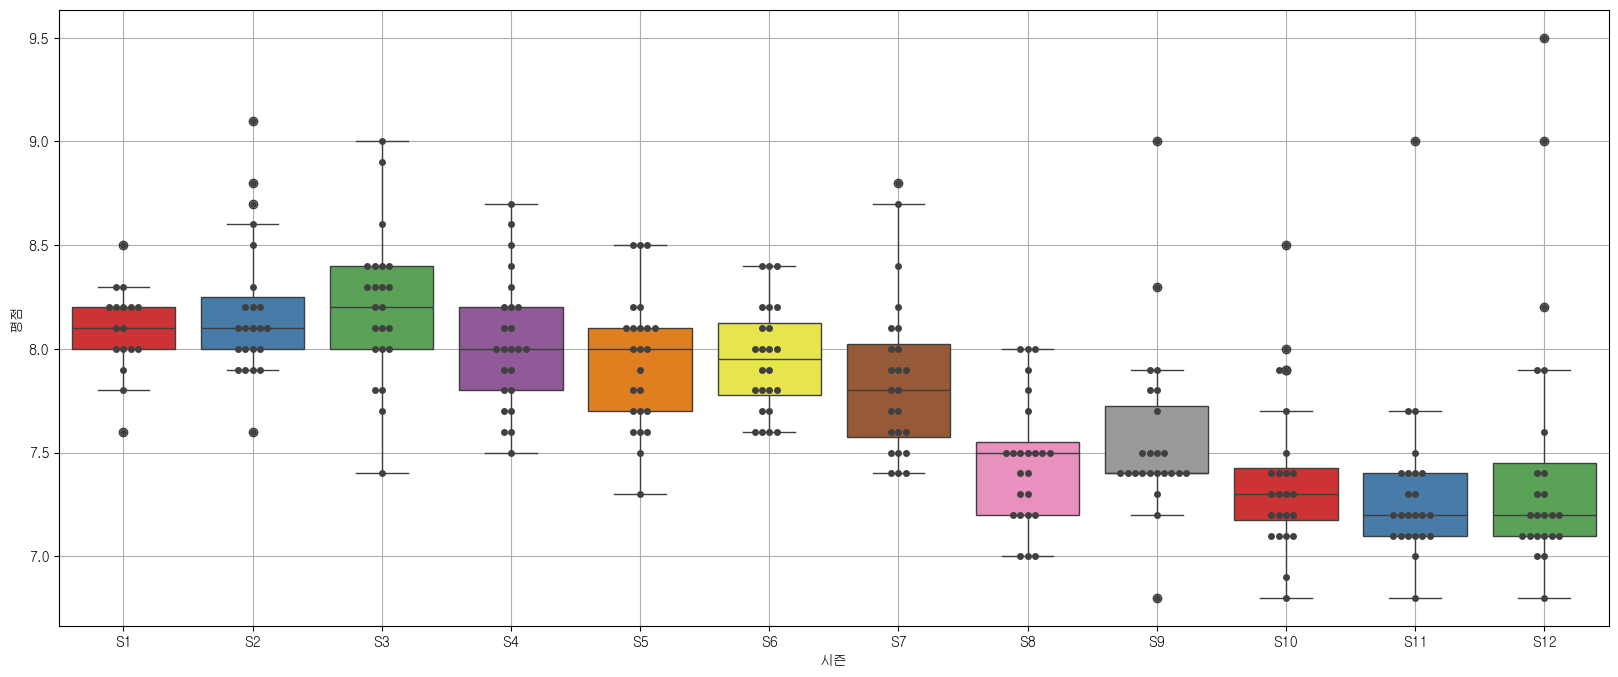

In [12]:
plt.figure (figsize=(20,8))
sns.boxplot(x="시즌", y="평점", data = bigbang_df, palette="Set1")
sns.swarmplot(x="시즌", y="평점", data = bigbang_df, color='.25')
plt.grid(True)
plt.show()

,평점
시즌,
S1,8.094118
S2,8.186957
S3,8.204348
S4,8.033333
S5,7.941667
S6,7.950000
S7,7.854167
S8,7.462500
S9,7.570833


C:\Users\rlawn\AppData\Local\Temp\ipykernel_10676\625277321.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="시즌", y="평점", data = best_season, palette="colorblind")


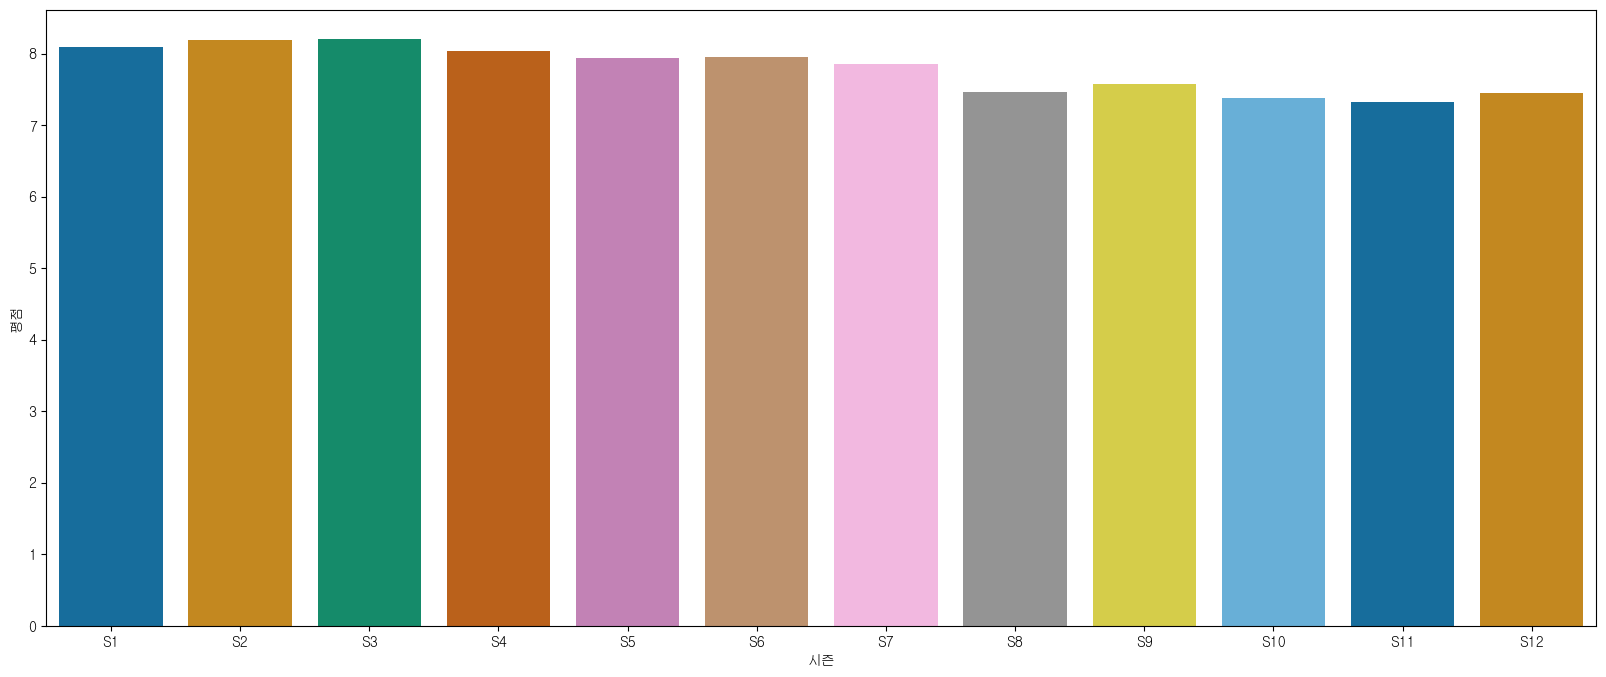

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from natsort import natsorted, order_by_index
#bigbang_df = pd.concat(bigbang_list)
best_season= bigbang_df.pivot_table(values = "평점", index="시즌", aggfunc="mean")
best_season = best_season.reindex(natsorted(best_season.index))
display(best_season)
plt.figure (figsize=(20,8))
sns.barplot(x="시즌", y="평점", data = best_season, palette="colorblind")
plt.show()

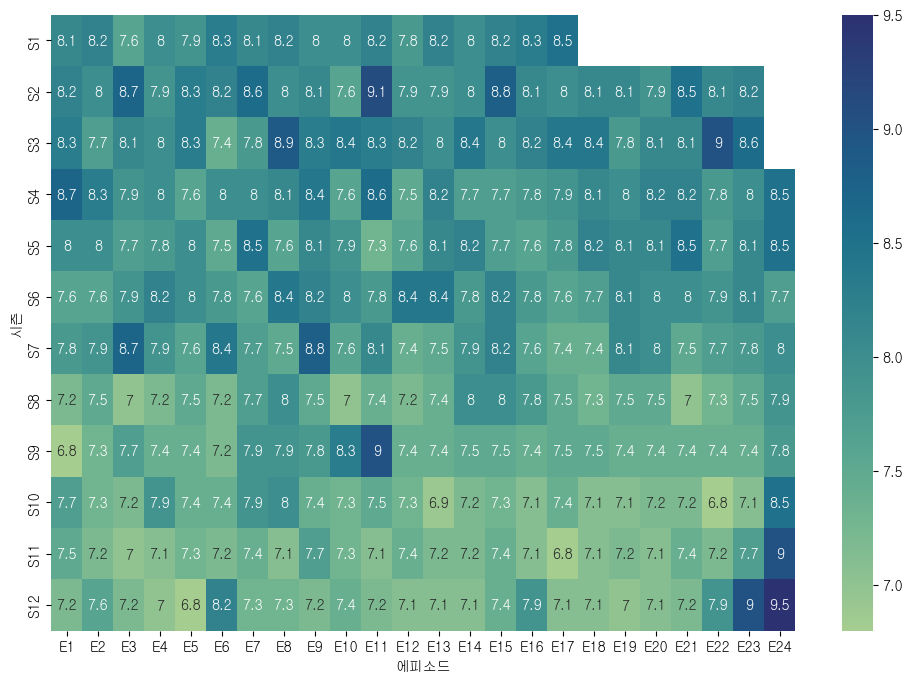

In [344]:
best_episode = bigbang_df.pivot_table(index = '시즌', columns = '에피소드', values = '평점f')
best_episode = best_episode.reindex(natsorted(best_episode.index))
best_episode = best_episode[natsorted(best_episode.columns)]
plt.figure(figsize = (12,8) )
sns.heatmap(best_episode, annot =True,  cmap="crest")
plt.show()
